In [1]:
import pandas
import sklearn
import numpy
import mongoTokens
import seaborn
import matplotlib
import flaml

numpy.random.seed(42)

In [2]:
data = pandas.read_csv("../Dataset/final.csv")
data.head()

,filter_str,denamed,queryLength,whereDetected,regexDetected,logicOperator,MathOperator,Size,thisPointer,matcherOption,cpuNanos,planningTimeMicros,label
0,"{'user': '{}', 'password': '{}'}","{'': '{}', '': '{}'}",32,0,0,0,0,0,0,0,176371,83.0,0.0
1,"{'user': '{}', 'password': '{}'}","{'': '{}', '': '{}'}",32,0,0,0,0,0,0,0,176371,83.0,0.0
2,{'username': {'$regex': '^{}'}},{'': {'$regex': ''}},31,0,1,0,0,0,0,0,112781,71.0,1.0
3,{'username': {'$regex': '^{}'}},{'': {'$regex': ''}},31,0,1,0,0,0,0,0,112781,71.0,1.0
4,{'username': {'$ne': '{}'}},{'': {'$ne': '{}'}},27,0,0,1,0,0,0,0,71093,42.0,1.0


In [3]:
featureFilter = data['filter_str']
featureDename = data['denamed']
featureQuery = data[['whereDetected','regexDetected','logicOperator','thisPointer','matcherOption']].values
featureDirtyQuery =data['queryLength'].values
featureLog = data['planningTimeMicros'].values
featuresDirtyLog = data['cpuNanos'].values
target = data['label']

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
cvFilter = CountVectorizer(tokenizer=mongoTokens.custom_tokenizer)
cvDename = CountVectorizer(tokenizer=mongoTokens.dename_tokenizer)
vectorizedFilter = cvFilter.fit_transform(featureFilter)
vectorizedDename = cvDename.fit_transform(featureDename)
scaledFeatureQuery = scaler.fit_transform(featureQuery)
scaledFeatureDirtyQuery = scaler.fit_transform(featureDirtyQuery.reshape(-1, 1))
scaledFeatureLog = scaler.fit_transform(featureLog.reshape(-1, 1))
scaledfeaturesDirtyLog = scaler.fit_transform(featuresDirtyLog.reshape(-1, 1))

/mnt/Data/Projects/ShaunakPerniUniGoa/NoSQLInjectionDetection/NoSQLInjectionDetectionVENV/lib64/python3.12/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [5]:
from scipy.sparse import hstack

XA1 = vectorizedFilter
XA1Names = ['filter_str']
XA2 = vectorizedDename
XB1Names = ['dename']
XB1 = hstack((vectorizedFilter,scaledFeatureQuery))
XB2 = hstack((vectorizedDename,scaledFeatureQuery))
XC = featureQuery
XE1 = hstack((vectorizedFilter,scaledFeatureQuery,scaledFeatureLog))
XE2 = hstack((vectorizedDename,scaledFeatureQuery,scaledFeatureLog))
XF1 = hstack((vectorizedFilter,featureQuery,scaledFeatureQuery,scaledFeatureLog,scaledfeaturesDirtyLog))
XF2 = hstack((vectorizedDename,featureQuery,scaledFeatureQuery,scaledFeatureLog,scaledfeaturesDirtyLog))
datasets = [XA1,XA2,XB1,XB2,XC,XE1,XE2,XF1,XF2]
target = target

In [6]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import ExtraTreesClassifier

svm_A_liner = SVC(kernel="linear",verbose=1)
svm_A_poly = SVC(kernel="poly",verbose=1)
svm_A_rbf = SVC(kernel="rbf",verbose=1)
svm_A_sig = SVC(kernel="sigmoid",verbose=1)
log_A = LogisticRegression(verbose=1)
randF_A = RandomForestClassifier(verbose=1)
gbc_A = GradientBoostingClassifier(verbose=1)
knn = KNeighborsClassifier(n_neighbors=7)
dt_clf = DecisionTreeClassifier()
bag_dt = BaggingClassifier()
ada_dt = AdaBoostClassifier()
bayes = MultinomialNB()
ext_tree = ExtraTreesClassifier()
hist_grad = HistGradientBoostingClassifier()

In [7]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

# Define the models
models = {
    "Linear SVM": svm_A_liner,
    "Polynomial SVM": svm_A_poly,
    "RBF SVM": svm_A_rbf,
    "Sigmoid SVM": svm_A_sig,
    "Logistic Regression": log_A,
    "Random Forrest": randF_A,
    "Gradient Boost": GradientBoostingClassifier(verbose=1),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "Decision Tree": DecisionTreeClassifier(),
    "Bagging": BaggingClassifier(),
    "Ada Boost": AdaBoostClassifier(),
    "Navie Bayes": MultinomialNB(),
    "Extra Tree": ext_tree
    
}

# Define the datasets
datasets = {
    "A1": XA1,
    "A2": XA2,
    "B1": XB1,
    "B2": XB2,
    "C": XC,
    "D1": XE1,
    "D2": XE2,
}

results_dict = {}

# Loop through each dataset
for dataset_name, dataset in datasets.items():
    print(dataset_name)
    # Split the data into train, validate, and test sets
    X_train, X_test, y_train, y_test = train_test_split(dataset, target, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

    # Create a dictionary to store model results for the current dataset
    dataset_results = {}

    # Loop through each model
    for model_name, model in models.items():
        print(model_name)
        # Train the model
        model.fit(X_train, y_train)

        # Evaluate on the validation set
        val_predictions = model.predict(X_val)
        val_cm = confusion_matrix(y_val, val_predictions)
        val_TN, val_FP, val_FN, val_TP = val_cm.ravel()
        val_accuracy = accuracy_score(y_val, val_predictions)
        val_precision = precision_score(y_val, val_predictions)
        val_recall = recall_score(y_val, val_predictions)
        val_f1 = f1_score(y_val, val_predictions)

        # Evaluate on the test set
        test_predictions = model.predict(X_test)
        test_cm = confusion_matrix(y_test, test_predictions)
        test_TN, test_FP, test_FN, test_TP = test_cm.ravel()
        test_accuracy = accuracy_score(y_test, test_predictions)
        test_precision = precision_score(y_test, test_predictions)
        test_recall = recall_score(y_test, test_predictions)
        test_f1 = f1_score(y_test, test_predictions)

        # Store results in model dictionary
        model_results = {
            "Validation": {
                "TN": val_TN,
                "FP": val_FP,
                "FN": val_FN,
                "TP": val_TP,
                "Accuracy": val_accuracy,
                "Precision": val_precision,
                "Recall": val_recall,
                "F1 Score": val_f1
            },
            "Test": {
                "TN": test_TN,
                "FP": test_FP,
                "FN": test_FN,
                "TP": test_TP,
                "Accuracy": test_accuracy,
                "Precision": test_precision,
                "Recall": test_recall,
                "F1 Score": test_f1
            }
        }

        # Add model results to dataset dictionary
        dataset_results[model_name] = model_results

    # Add dataset dictionary to main results dictionary
    results_dict[dataset_name] = dataset_results


A1
Linear SVM
[LibSVM].*.*
optimization finished, #iter = 221
obj = -22.906190, rho = 0.233652
nSV = 60, nBSV = 14
Total nSV = 60
Polynomial SVM
[LibSVM]*.*
optimization finished, #iter = 93
obj = -44.993228, rho = 0.590910
nSV = 73, nBSV = 45
Total nSV = 73
RBF SVM
[LibSVM]*.*
optimization finished, #iter = 104
obj = -41.359755, rho = -0.194832
nSV = 79, nBSV = 37
Total nSV = 79
Sigmoid SVM
[LibSVM]*.*
optimization finished, #iter = 116
obj = -54.776752, rho = 0.336495
nSV = 81, nBSV = 58
Total nSV = 81
Logistic Regression
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          132     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  7.86517D-02


 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  132     12     13      1     0     0   6.612D-05   4.333D-01
  F =  0.43325145546664978     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Random Forrest
Gradient Boost
      Iter       Train Loss   Remaining Time 
         1           1.3137            0.12s
         2           1.2573            0.09s
         3           1.2088            0.08s
         4           1.1679            0.08s
         5           1.1342            0.07s
         6           1.1002            0.07s
         7           1.0729            0.07s
         8           1.0485     

/mnt/Data/Projects/ShaunakPerniUniGoa/NoSQLInjectionDetection/NoSQLInjectionDetectionVENV/lib64/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Navie Bayes
Extra Tree
A2
Linear SVM
[LibSVM].
*
optimization finished, #iter = 110
obj = -61.999997, rho = -0.999410
nSV = 79, nBSV = 65
Total nSV = 79
Polynomial SVM
[LibSVM]*
optimization finished, #iter = 71
obj = -50.769981, rho = -0.999788
nSV = 68, nBSV = 55
Total nSV = 68
RBF SVM
[LibSVM]*
optimization finished, #iter = 60
obj = -49.984968, rho = 0.743086
nSV = 68, nBSV = 50
Total nSV = 68
Sigmoid SVM
[LibSVM]*
optimization finished, #iter = 53
obj = -72.297752, rho = -1.000000
nSV = 81, nBSV = 72
Total nSV = 81
Logistic Regression
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.49438D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of acti

 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Gradient Boost
      Iter       Train Loss   Remaining Time 
         1           1.3564            0.08s
         2           1.3364            0.08s
         3           1.3179            0.07s
         4           1.3040            0.07s
         5           1.2890            0.07s
         6           1.2770            0.07s
         7           1.2646            0.06s
         8           1.2547            0.06s
         9           1.2411            0.06s
        10           1.2232            0.06s
        20           1.1409            0.04s
        30           1.0943            0.04s
        40           1.0546            0.03s
        50           1.0230            0.03s
        60           1.0012            0.02s
        70           0.9809            0.02s
        80           0.9688            0.01s
        90           0.9573            0.01s
       100           0.9491            0.00s
KNN
Decision Tree
Bagging
Ada Boost


/mnt/Data/Projects/ShaunakPerniUniGoa/NoSQLInjectionDetection/NoSQLInjectionDetectionVENV/lib64/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Navie Bayes
Extra Tree
B1
Linear SVM
[LibSVM].*.*
optimization finished, #iter = 235
obj = -22.181208, rho = 0.118231
nSV = 61, nBSV = 14
Total nSV = 61
Polynomial SVM
[LibSVM]*.*
optimization finished, #iter = 93
obj = -44.866141, rho = 0.322841
nSV = 72, nBSV = 40
Total nSV = 72
RBF SVM
[LibSVM]*.*
optimization finished, #iter = 92
obj = -41.953797, rho = -0.128710
nSV = 78, nBSV = 43
Total nSV = 78
Sigmoid SVM
[LibSVM]*.*
optimization finished, #iter = 93
obj = -54.857623, rho = 0.108659
nSV = 75, nBSV = 52
Total nSV = 75
Logistic Regression
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          137     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  7.86517D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of

 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Gradient Boost
      Iter       Train Loss   Remaining Time 
         1           1.3137            0.10s
         2           1.2573            0.08s
         3           1.2088            0.08s
         4           1.1679            0.07s
         5           1.1342            0.07s
         6           1.1002            0.07s
         7           1.0729            0.07s
         8           1.0485            0.07s
         9           1.0238            0.07s
        10           1.0003            0.07s
        20           0.8469            0.06s
        30           0.7413            0.05s
        40           0.6656            0.04s
        50           0.6005            0.04s
        60           0.5513            0.03s
        70           0.5039            0.02s
        80           0.4518            0.01s
        90           0.4078            0.01s
       100           0.3731            0.00s
KNN
Decision Tree
Bagging
Ada Boost


/mnt/Data/Projects/ShaunakPerniUniGoa/NoSQLInjectionDetection/NoSQLInjectionDetectionVENV/lib64/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Navie Bayes
Extra Tree
B2
Linear SVM
[LibSVM]*
optimization finished, #iter = 64
obj = -58.571428, rho = -0.999495
nSV = 68, nBSV = 58
Total nSV = 68
Polynomial SVM
[LibSVM]*
optimization finished, #iter = 74
obj = -51.043838, rho = -0.999887
nSV = 62, nBSV = 49
Total nSV = 62
RBF SVM
[LibSVM]*
optimization finished, #iter = 64
obj = -51.559159, rho = 0.698494
nSV = 70, nBSV = 54
Total nSV = 70
Sigmoid SVM
[LibSVM]*
optimization finished, #iter = 53
obj = -71.799949, rho = -1.000480
nSV = 75, nBSV = 68
Total nSV = 75
Logistic Regression
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  6.74157D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active 

 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Gradient Boost
      Iter       Train Loss   Remaining Time 
         1           1.3311            0.09s
         2           1.2909            0.10s
         3           1.2734            0.10s
         4           1.2421            0.09s
         5           1.2229            0.08s
         6           1.2116            0.08s
         7           1.2022            0.07s
         8           1.1772            0.07s
         9           1.1636            0.07s
        10           1.1566            0.06s
        20           1.0878            0.05s
        30           1.0366            0.06s
        40           1.0032            0.05s
        50           0.9802            0.04s
        60           0.9598            0.03s
        70           0.9459            0.02s
        80           0.9348            0.01s
        90           0.9269            0.01s
       100           0.9218            0.00s
KNN
Decision Tree
Bagging
Ada Boost


/mnt/Data/Projects/ShaunakPerniUniGoa/NoSQLInjectionDetection/NoSQLInjectionDetectionVENV/lib64/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Navie Bayes
Extra Tree
C
Linear SVM
[LibSVM]*
optimization finished, #iter = 55
obj = -65.999999, rho = -0.999349
nSV = 70, nBSV = 67
Total nSV = 70
Polynomial SVM
[LibSVM]*
optimization finished, #iter = 50
obj = -59.051146, rho = -0.999810
nSV = 62, nBSV = 57
Total nSV = 62
RBF SVM
[LibSVM]*
optimization finished, #iter = 44
obj = -59.972255, rho = 0.711252
nSV = 66, nBSV = 57
Total nSV = 66
Sigmoid SVM
[LibSVM]*
optimization finished, #iter = 53
obj = -68.032809, rho = -0.999544
nSV = 73, nBSV = 69
Total nSV = 73
Logistic Regression
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  6.74157D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active b

 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Gradient Boost
      Iter       Train Loss   Remaining Time 
         1           1.3529            0.11s
         2           1.3308            0.09s
         3           1.3126            0.08s
         4           1.2975            0.08s
         5           1.2850            0.08s
         6           1.2746            0.08s
         7           1.2659            0.07s
         8           1.2586            0.07s
         9           1.2525            0.07s
        10           1.2473            0.06s
        20           1.2232            0.05s
        30           1.2174            0.05s
        40           1.2156            0.04s
        50           1.2150            0.03s
        60           1.2148            0.03s
        70           1.2147            0.02s
        80           1.2147            0.01s
        90           1.2147            0.01s
       100           1.2147            0.00s
KNN
Decision Tree
Bagging
Ada Boost


/mnt/Data/Projects/ShaunakPerniUniGoa/NoSQLInjectionDetection/NoSQLInjectionDetectionVENV/lib64/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Navie Bayes
Extra Tree
D1
Linear SVM
[LibSVM].*.*
optimization finished, #iter = 225
obj = -22.177453, rho = 0.110683
nSV = 58, nBSV = 14
Total nSV = 58
Polynomial SVM
[LibSVM]*.*
optimization finished, #iter = 109
obj = -44.840801, rho = 0.304271
nSV = 72, nBSV = 40
Total nSV = 72
RBF SVM
[LibSVM]*.*
optimization finished, #iter = 99
obj = -41.997121, rho = -0.117169
nSV = 79, nBSV = 44
Total nSV = 79
Sigmoid SVM
[LibSVM]*
optimization finished, #iter = 86
obj = -54.834430, rho = 0.088360
nSV = 76, nBSV = 55
Total nSV = 76
Logistic Regression
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          138     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  7.86517D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of 

 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Gradient Boost
      Iter       Train Loss   Remaining Time 
         1           1.3065            0.10s
         2           1.2450            0.11s
         3           1.1918            0.16s
         4           1.1452            0.19s
         5           1.1113            0.20s
         6           1.0731            0.20s
         7           1.0457            0.19s
         8           1.0231            0.17s
         9           0.9979            0.16s
        10           0.9727            0.14s
        20           0.8051            0.09s
        30           0.7065            0.07s
        40           0.6335            0.05s
        50           0.5754            0.04s
        60           0.5139            0.03s
        70           0.4707            0.02s
        80           0.4218            0.02s
        90           0.3722            0.01s
       100           0.3422            0.00s
KNN
Decision Tree
Bagging
Ada Boost


/mnt/Data/Projects/ShaunakPerniUniGoa/NoSQLInjectionDetection/NoSQLInjectionDetectionVENV/lib64/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Navie Bayes
Extra Tree
D2
Linear SVM
[LibSVM]*
optimization finished, #iter = 69
obj = -58.571429, rho = -0.999894
nSV = 70, nBSV = 58
Total nSV = 70
Polynomial SVM
[LibSVM]*.
*
optimization finished, #iter = 90
obj = -51.124541, rho = -0.999664
nSV = 64, nBSV = 51
Total nSV = 64
RBF SVM
[LibSVM]*
optimization finished, #iter = 87
obj = -51.575793, rho = 0.704772
nSV = 74, nBSV = 53
Total nSV = 74
Sigmoid SVM
[LibSVM]*
optimization finished, #iter = 72
obj = -71.984828, rho = -1.016224
nSV = 75, nBSV = 69
Total nSV = 75
Logistic Regression
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  6.74157D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of acti

 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Gradient Boost
      Iter       Train Loss   Remaining Time 
         1           1.3440            0.15s
         2           1.3135            0.12s
         3           1.2875            0.10s
         4           1.2471            0.10s
         5           1.2262            0.10s
         6           1.2082            0.09s
         7           1.1724            0.09s
         8           1.1572            0.08s
         9           1.1318            0.08s
        10           1.1193            0.08s
        20           0.9825            0.06s
        30           0.9030            0.05s
        40           0.8373            0.04s
        50           0.7834            0.04s
        60           0.7256            0.03s
        70           0.6671            0.02s
        80           0.6253            0.02s
        90           0.5638            0.01s
       100           0.5251            0.00s
KNN
Decision Tree
Bagging
Ada Boost
Navie Bayes
Extra Tree


/mnt/Data/Projects/ShaunakPerniUniGoa/NoSQLInjectionDetection/NoSQLInjectionDetectionVENV/lib64/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [62]:
# Convert nested dictionary to DataFrame
results_df = pd.DataFrame.from_dict(
    {(dataset_name, model_name, 'Validation'): model_results['Validation']
     for dataset_name, dataset_results in results_dict.items()
     for model_name, model_results in dataset_results.items()},
    orient='index'
)

results_df = results_df.reset_index()
results_df = results_df.rename(columns={'level_0': 'Dataset', 'level_1': 'Model', 'level_2': 'Split'})

# Convert nested dictionary to DataFrame for test results
test_results_df = pd.DataFrame.from_dict(
    {(dataset_name, model_name, 'Test'): model_results['Test']
     for dataset_name, dataset_results in results_dict.items()
     for model_name, model_results in dataset_results.items()},
    orient='index'
)

test_results_df = test_results_df.reset_index()
test_results_df = test_results_df.rename(columns={'level_0': 'Dataset', 'level_1': 'Model', 'level_2': 'Split'})

# Concatenate validation and test results
combined_results_df = pd.concat([results_df, test_results_df], ignore_index=True)

# Now combined_results_df is a DataFrame with dataset, model, split, and corresponding metrics as columns
combined_results_df.to_csv("rsults.csv")

In [63]:
combined_results_df

,Dataset,Model,Split,TN,FP,FN,TP,Accuracy,Precision,Recall,F1 Score
0,A1,Linear SVM,Validation,38,16,5,31,0.766667,0.659574,0.861111,0.746988
1,A1,Polynomial SVM,Validation,25,29,3,33,0.644444,0.532258,0.916667,0.673469
2,A1,RBF SVM,Validation,33,21,5,31,0.711111,0.596154,0.861111,0.704545
3,A1,Sigmoid SVM,Validation,37,17,11,25,0.688889,0.595238,0.694444,0.641026
4,A1,Logistic Regression,Validation,37,17,7,29,0.733333,0.630435,0.805556,0.707317
...,...,...,...,...,...,...,...,...,...,...,...
177,D2,Decision Tree,Test,15,10,8,12,0.600000,0.545455,0.600000,0.571429
178,D2,Bagging,Test,17,8,11,9,0.577778,0.529412,0.450000,0.486486
179,D2,Ada Boost,Test,13,12,5,15,0.622222,0.555556,0.750000,0.638298
180,D2,Navie Bayes,Test,5,20,4,16,0.466667,0.444444,0.800000,0.571429


In [64]:
avg_per_results = combined_results_df[combined_results_df['Split'] == "Test"][['Dataset','Accuracy', 'Precision', 'Recall',
       'F1 Score']]
avg_per_results = avg_per_results.groupby('Dataset').mean()

In [65]:
avg_per_results
avg_per_results.to_csv('modelResults.csv')

In [66]:
TestingDF = combined_results_df[combined_results_df['Split'] == "Test"][['Dataset','Accuracy', 'Precision', 'Recall',
       'F1 Score']]

TestingDF.head()

,Dataset,Accuracy,Precision,Recall,F1 Score
91,A1,0.688889,0.607143,0.85,0.708333
92,A1,0.577778,0.513514,0.95,0.666667
93,A1,0.688889,0.600000,0.90,0.720000
94,A1,0.711111,0.652174,0.75,0.697674
95,A1,0.688889,0.607143,0.85,0.708333


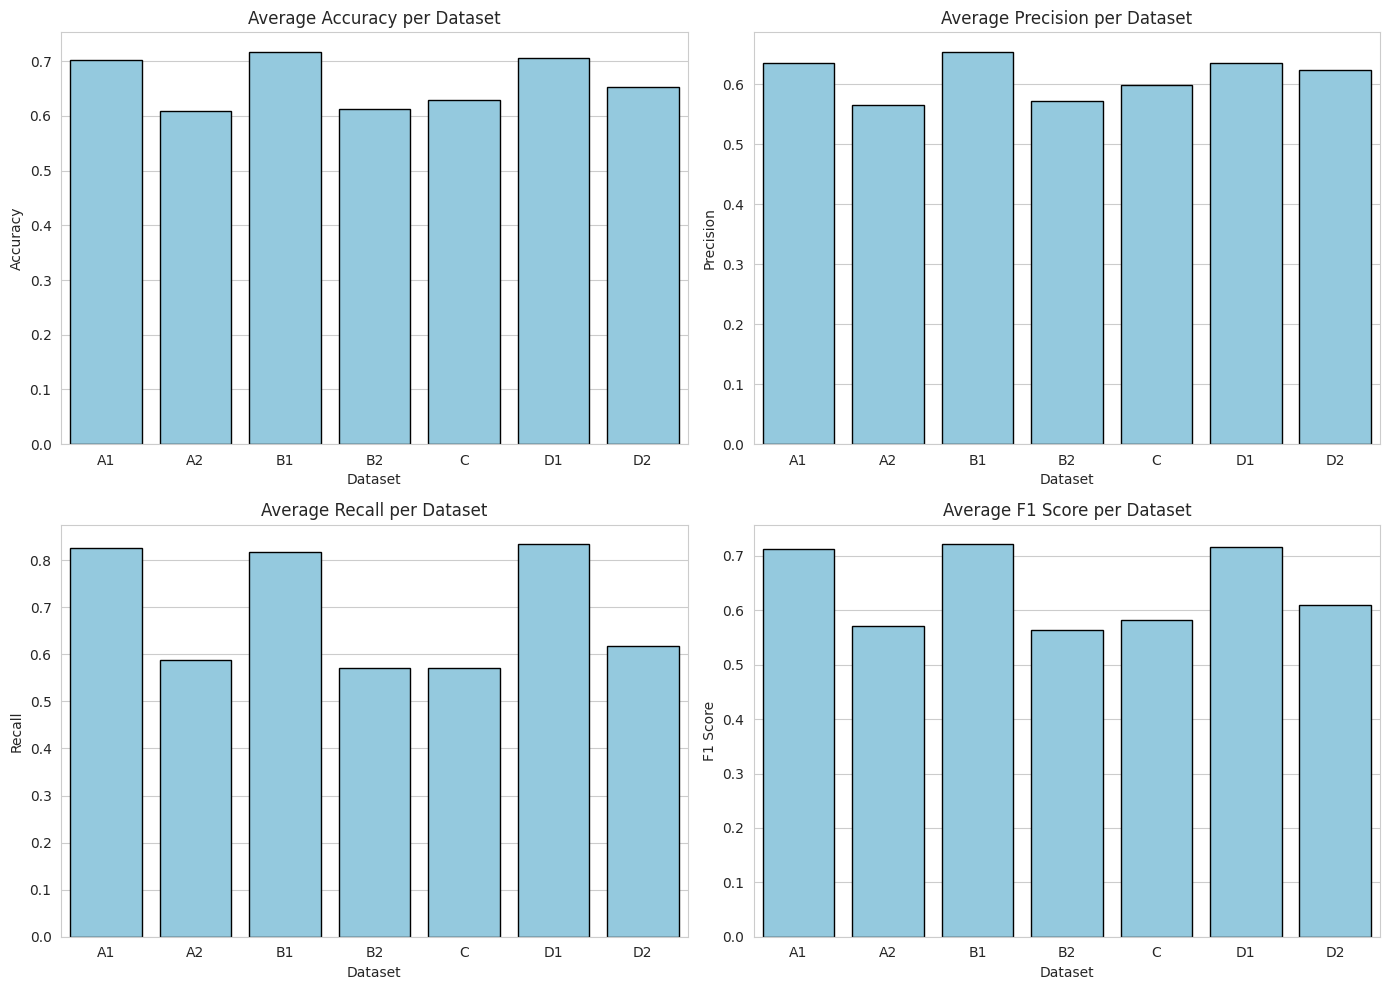

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
for i, column in enumerate(avg_per_results.columns):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    sns.barplot(x=avg_per_results.index, y=avg_per_results[column], ax=ax, color='skyblue', edgecolor='black')
    ax.set_title(f'Average {column} per Dataset')
    ax.set_xlabel('Dataset')
    ax.set_ylabel(column)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
dataset_results.keys()

dict_keys(['Linear SVM', 'Polynomial SVM', 'RBF SVM', 'Sigmoid SVM', 'Logistic Regression', 'Random Forrest', 'Gradient Boost', 'KNN', 'Decision Tree', 'Bagging', 'Ada Boost', 'Navie Bayes'])

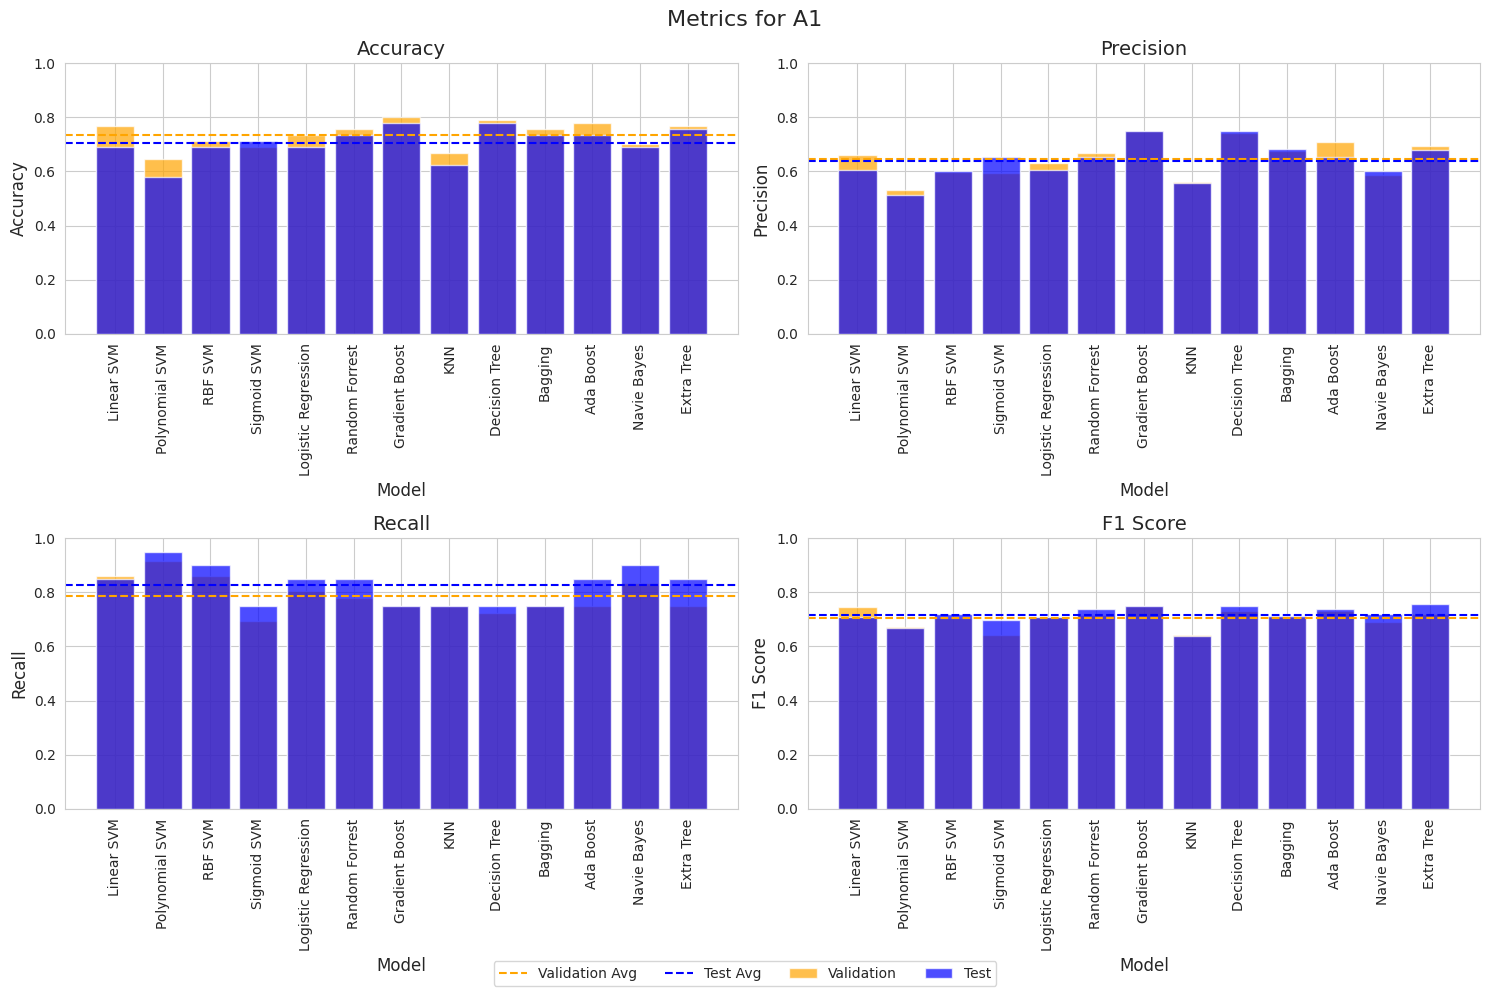

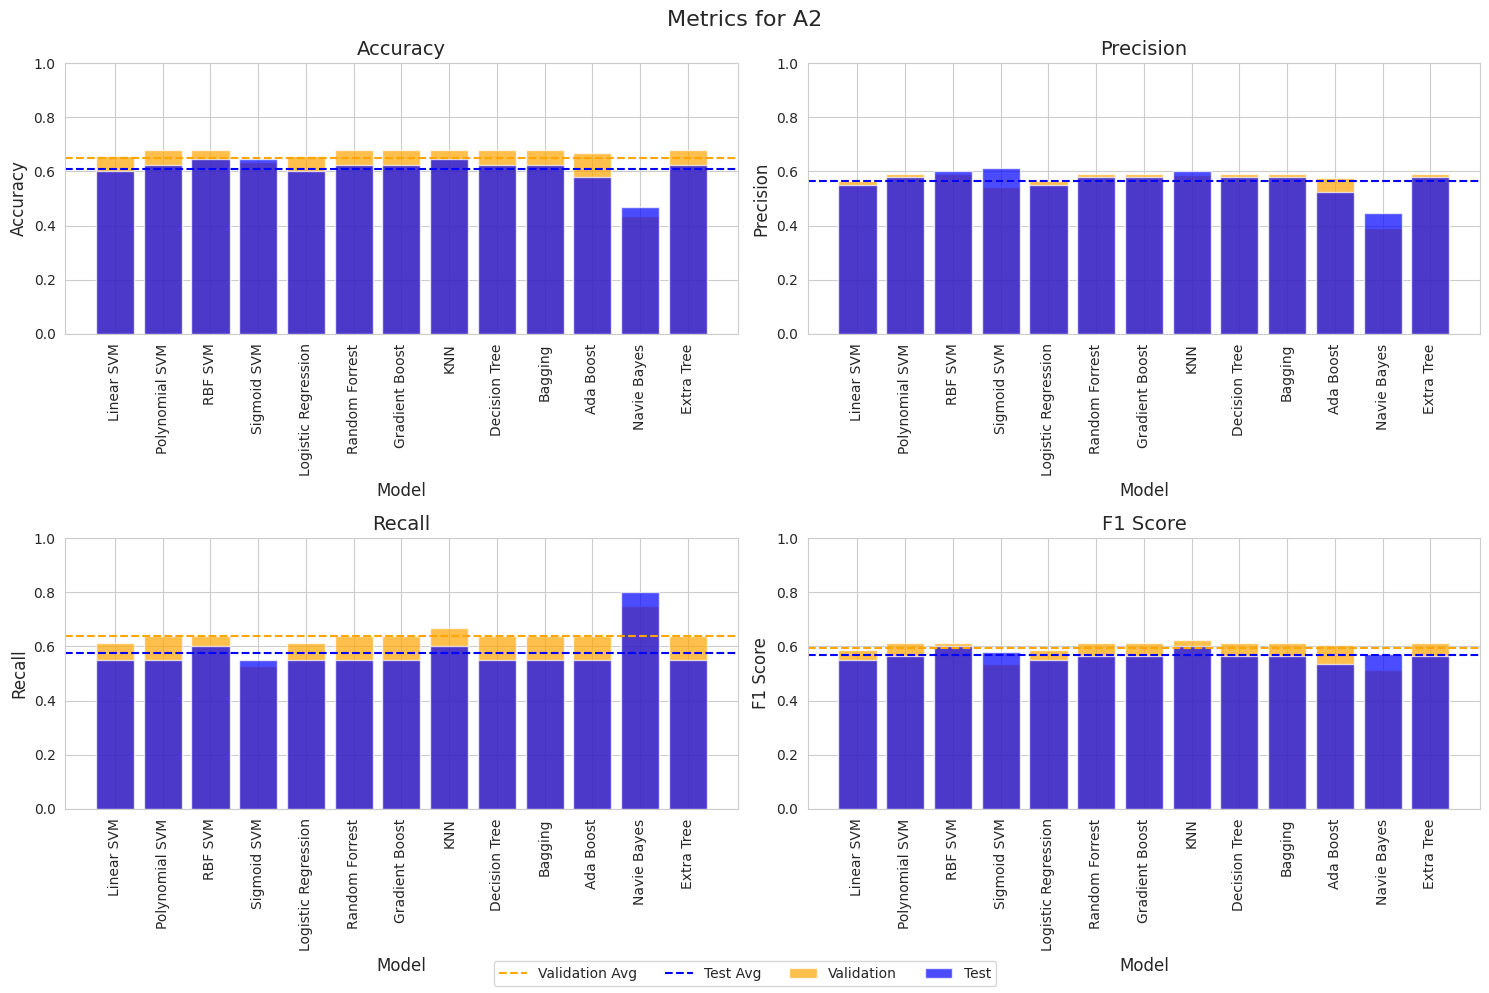

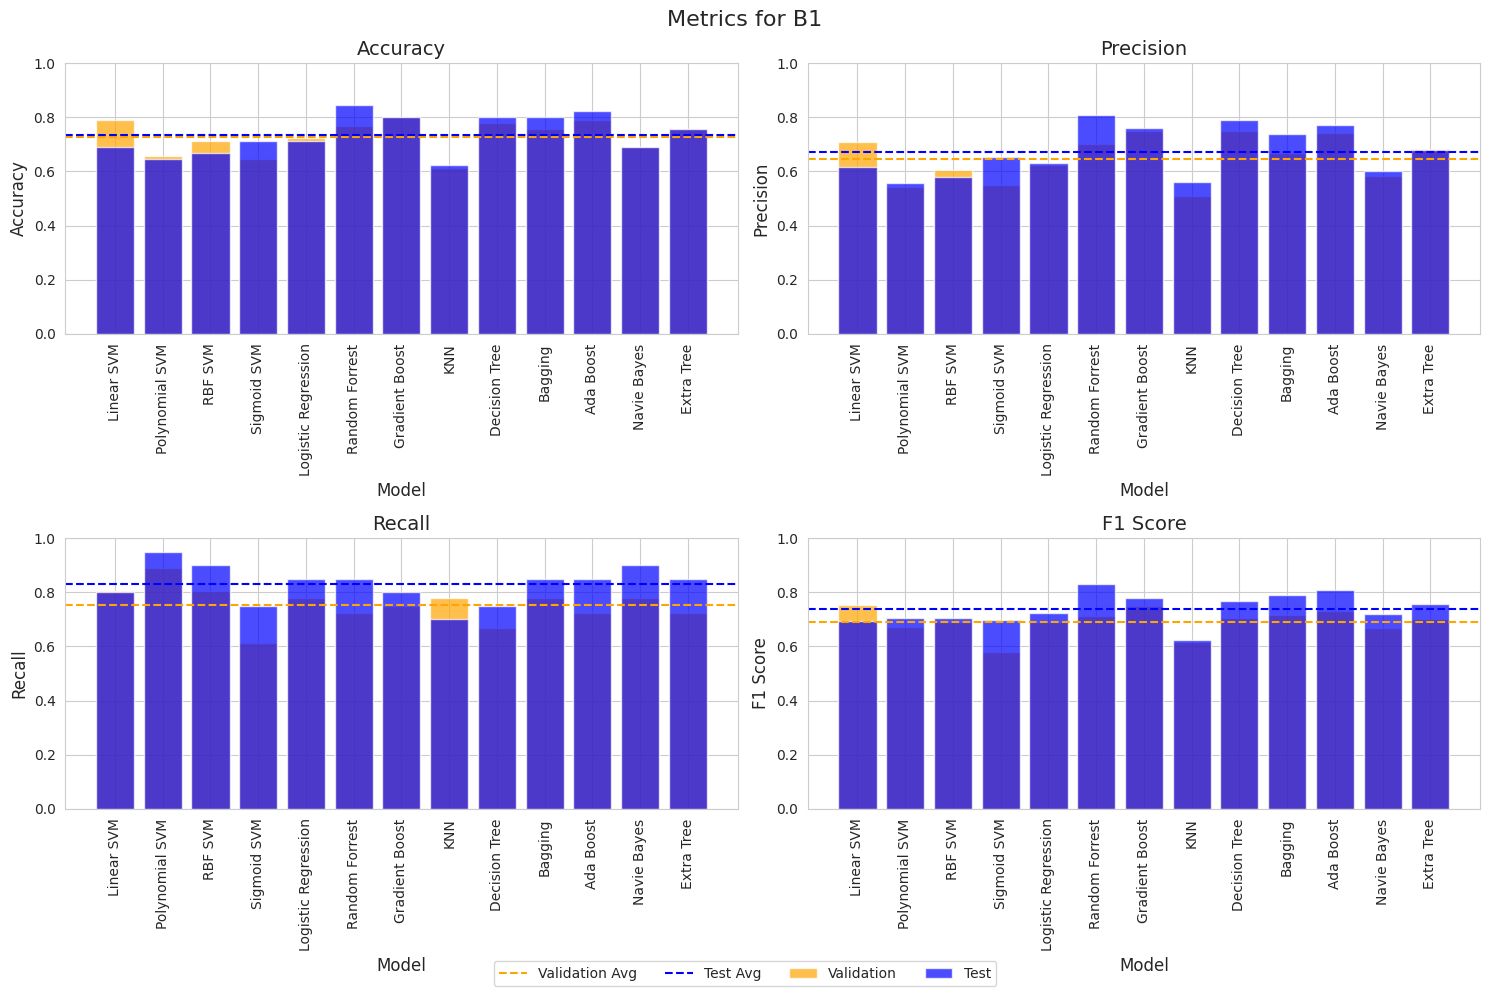

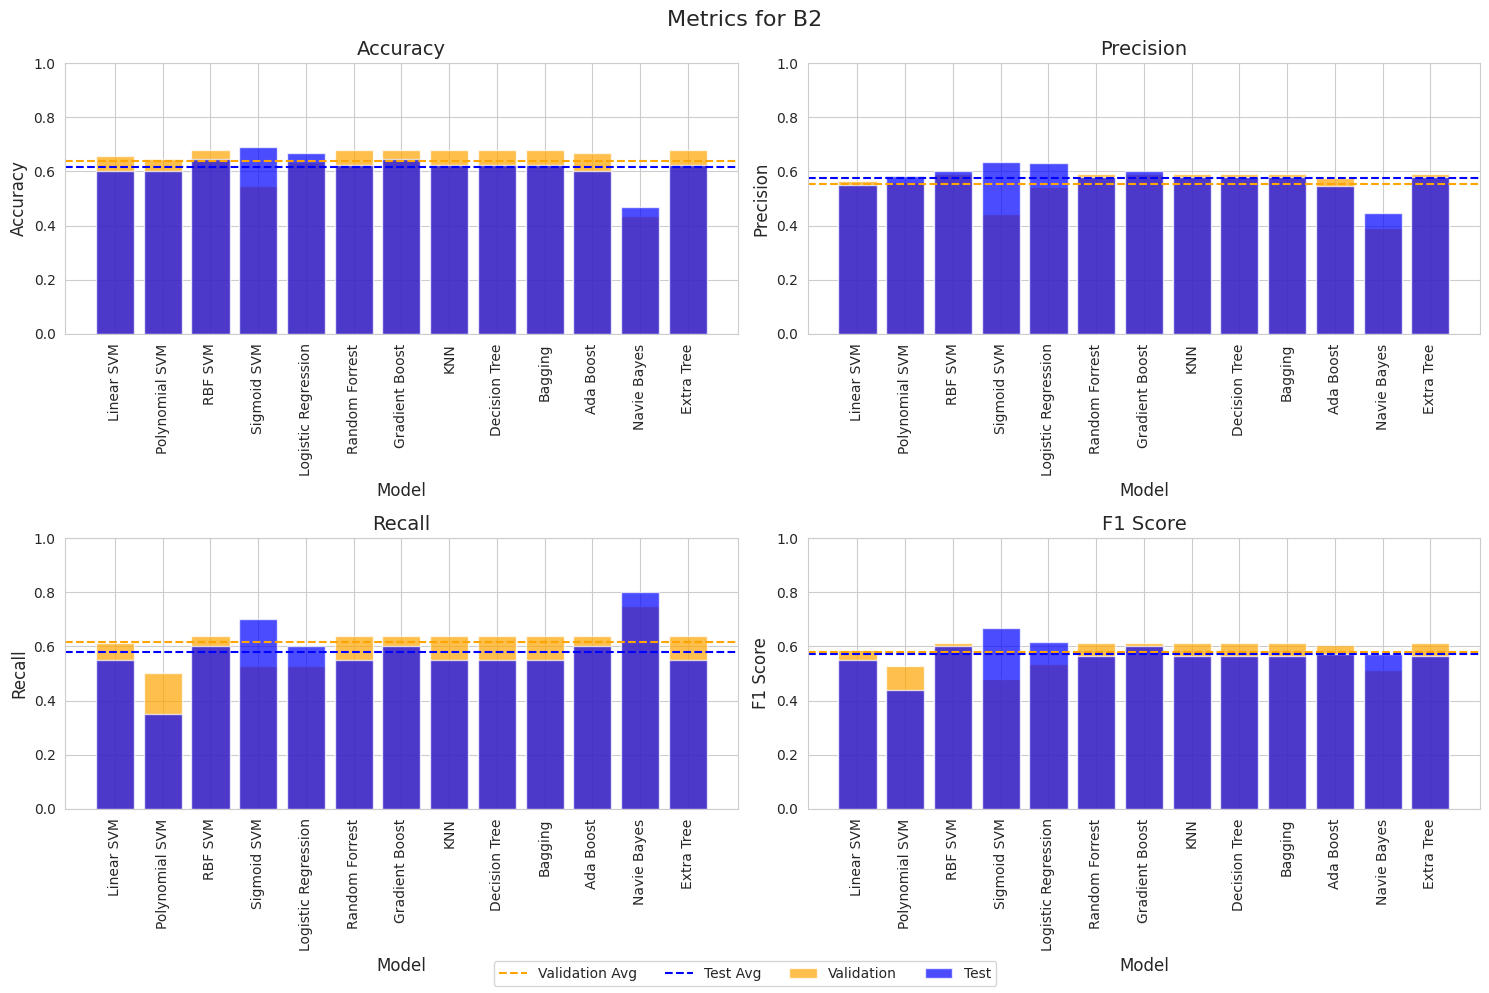

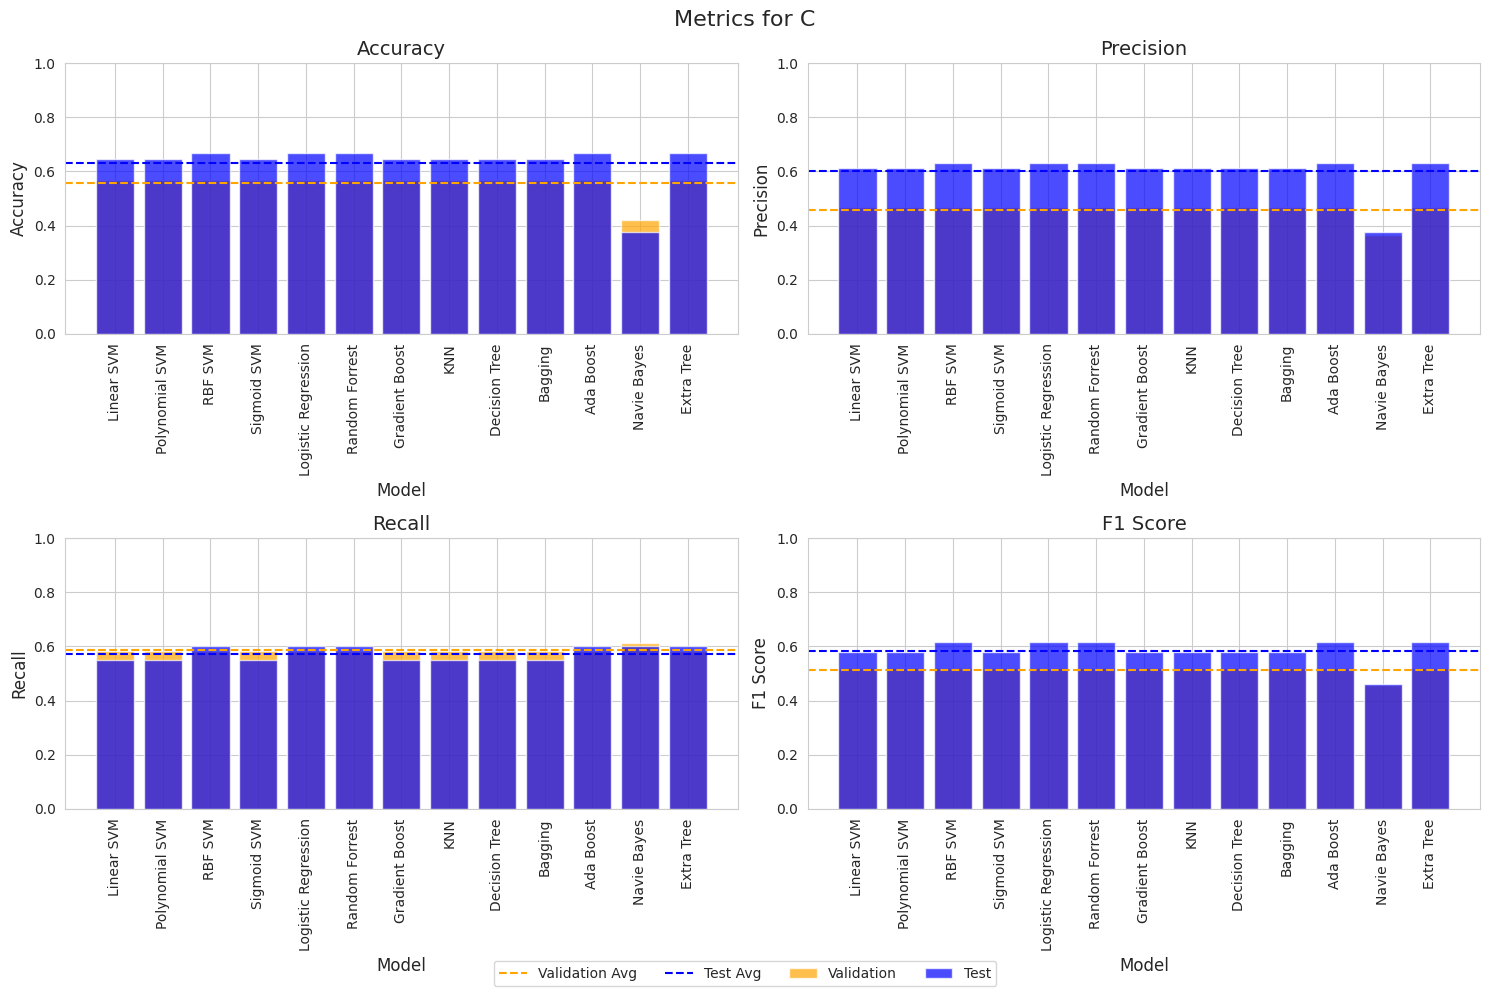

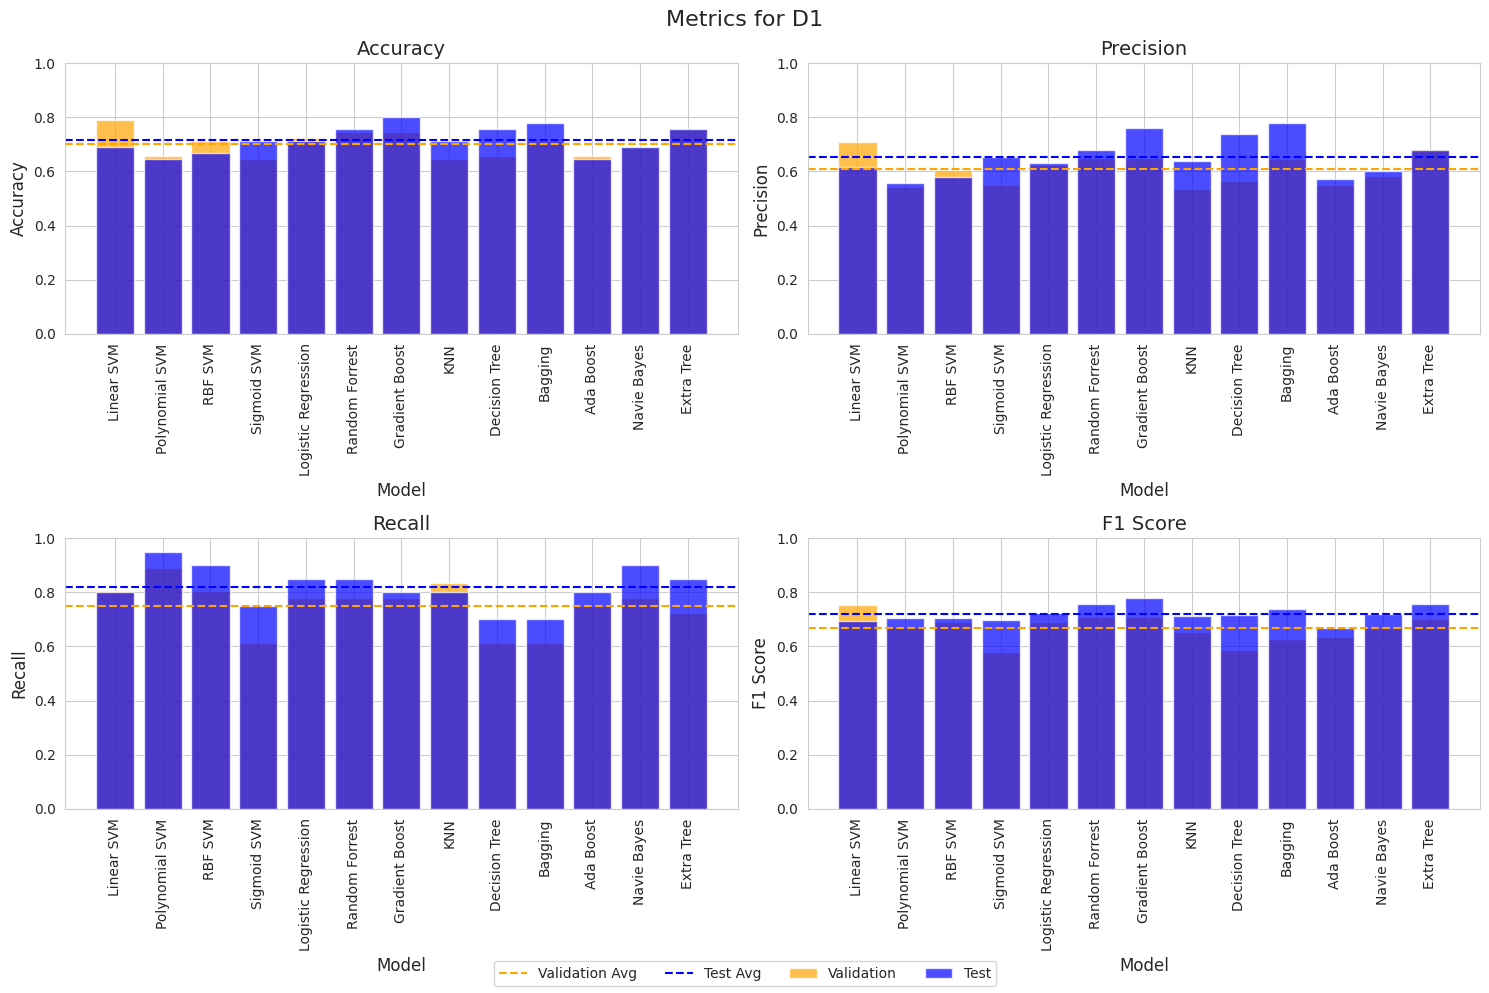

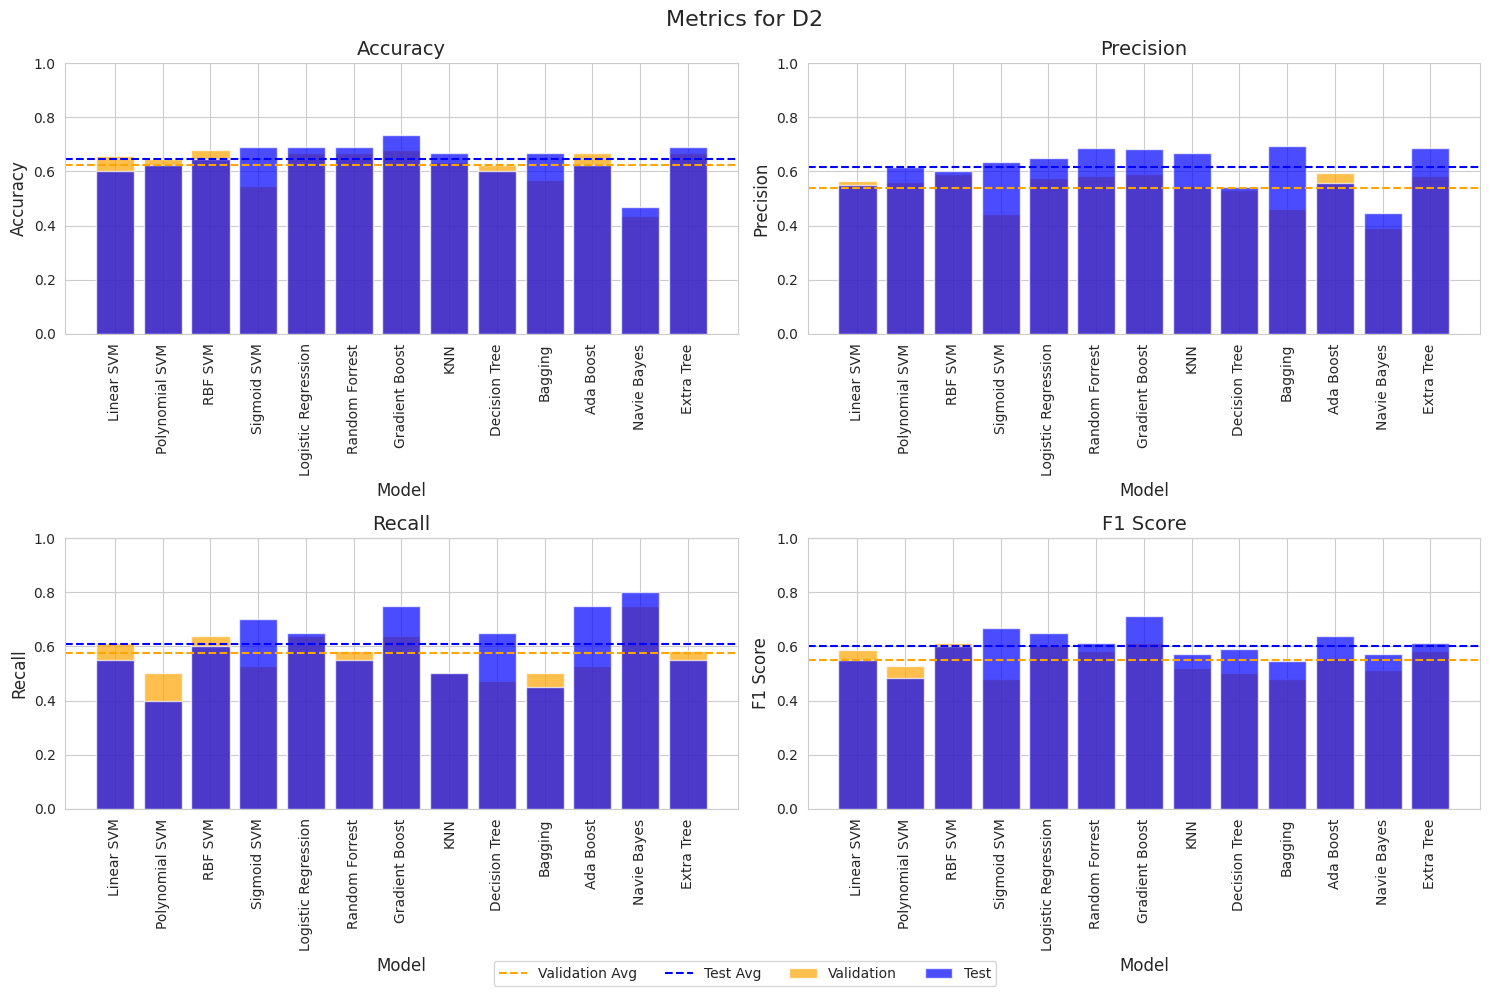

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set seaborn style
sns.set_style("whitegrid")

# List of metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Loop through each dataset
for dataset_name, dataset_results in results_dict.items():
    # Create subplots for each metric and split (validation and test)
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Metrics for {dataset_name}', fontsize=16)

    # Flatten axs for easier indexing
    axs = axs.flatten()

    # Loop through each metric
    for i, metric in enumerate(metrics):
        # Extract metric values for validation and test splits
        val_metric_values = [model_results['Validation'][metric] for model_results in dataset_results.values()]
        test_metric_values = [model_results['Test'][metric] for model_results in dataset_results.values()]

        # Compute average values
        val_avg = np.mean(val_metric_values)
        test_avg = np.mean(test_metric_values)

        # Plot metric values for validation
        axs[i].bar(dataset_results.keys(), val_metric_values, label='Validation', color='orange' , alpha=0.7)

        # Plot metric values for test
        axs[i].bar(dataset_results.keys(), test_metric_values, label='Test', color='blue', alpha=0.7)

        # Plot average lines
        axs[i].axhline(y=val_avg, color='orange', linestyle='--', label='Validation Avg')
        axs[i].axhline(y=test_avg, color='blue', linestyle='--', label='Test Avg')
        
        axs[i].set_title(metric, fontsize=14)
        axs[i].set_ylabel(metric, fontsize=12)
        axs[i].set_xlabel('Model', fontsize=12)
        axs[i].set_ylim(0, 1)
        axs[i].tick_params(axis='x', rotation=90)

    # Add a common legend
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=10)

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [ ]:
import flaml
from flaml import AutoML
from flaml import automl

datasets = {
    "A1": XA1,
    "A2": XA2,
    "B1": XB1,
    "B2": XB2,
    "C": XC,
    "D1": XE1,
    "D2": XE2,
}

automlModel = AutoML()

results_dict = []

# Loop through each dataset
for dataset_name, dataset in datasets.items():
    # Split the data into train, validate, and test sets
    X_train, X_test, y_train, y_test = train_test_split(dataset, target, test_size=0.2, random_state=42)
    automlModel.fit(X_train,y_train,task='classification', time_budget=1)
    y_pred = automlModel.predict(X_test)
    cm =  automl.ml.norm_confusion_matrix(y_test,y_pred)
    results_dict.append([dataset_name,automlModel,automlModel.best_estimator,automlModel.best_config,automlModel.score(X_test,y_test),cm])

results_dict

[flaml.automl.logger: 05-03 07:36:06] {1680} INFO - task = classification
[flaml.automl.logger: 05-03 07:36:06] {1691} INFO - Evaluation method: holdout
[flaml.automl.logger: 05-03 07:36:06] {1789} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 05-03 07:36:06] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 05-03 07:36:06] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 05-03 07:36:06] {2345} INFO - Estimated sufficient time budget=210s. Estimated necessary time budget=5s.
[flaml.automl.logger: 05-03 07:36:06] {2392} INFO -  at 0.0s,	estimator lgbm's best error=0.5354,	best estimator lgbm's best error=0.5354
[flaml.automl.logger: 05-03 07:36:06] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 05-03 07:36:06] {2392} INFO -  at 0.1s,	estimator lgbm's best error=0.5303,	best estimator lgbm's best error=0.5303
[flaml.automl.logger: 05-03 07:3

[['A1',
  AutoML(append_log=False, auto_augment=True, custom_hp={},
         cv_score_agg_func=None, early_stop=False, ensemble=False,
         estimator_list='auto', eval_method='auto', fit_kwargs_by_estimator={},
         force_cancel=False, free_mem_ratio=0, hpo_method='auto',
         keep_search_state=False, learner_selector='sample', log_file_name='',
         log_training_metric=False, log_type='better', max_iter=None,
         mem_thres=4294967296, metric='auto', metric_constraints=[],
         min_sample_size=10000, mlflow_logging=True, model_history=False,
         n_concurrent_trials=1, n_jobs=-1, n_splits=5, pred_time_limit=inf,
         preserve_checkpoint=True, retrain_full=True, ...),
  'xgboost',
  {'n_estimators': 8,
   'max_leaves': 5,
   'min_child_weight': 0.08280041283587716,
   'learning_rate': 0.6690043489102062,
   'subsample': 0.9480935223621957,
   'colsample_bylevel': 0.7814216072222443,
   'colsample_bytree': 0.9158265282522311,
   'reg_alpha': 0.00176078662

In [ ]:
dfList = []
for x in results_dict:
    cm = x[-1]
    accuracy = (cm.diagonal().sum() / cm.sum())
    precision = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    recall = cm[0, 0] / (cm[0, 0] + cm[1, 0])
    f1_score = 2 * (precision * recall) / (precision + recall)
    dfList.append({'Dataset':x[0],'Model':x[2],'Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1':f1_score})

cmDf = pandas.DataFrame(dfList)
cmDf.to_csv('FLAMLresults.csv')

In [ ]:
dataset_results_consolidated = combined_results_df[combined_results_df['Split'] == "Test"][['Dataset','Accuracy', 'Precision', 'Recall',
       'F1 Score']]
dataset_results_consolidated

,Dataset,Accuracy,Precision,Recall,F1 Score
84,A1,0.688889,0.607143,0.85,0.708333
85,A1,0.577778,0.513514,0.95,0.666667
86,A1,0.688889,0.600000,0.90,0.720000
87,A1,0.711111,0.652174,0.75,0.697674
88,A1,0.688889,0.607143,0.85,0.708333
...,...,...,...,...,...
163,D2,0.666667,0.666667,0.50,0.571429
164,D2,0.733333,0.722222,0.65,0.684211
165,D2,0.644444,0.625000,0.50,0.555556
166,D2,0.622222,0.555556,0.75,0.638298


In [ ]:
from scipy.stats import ttest_ind, mannwhitneyu
import pandas as pd

# Define a function to conduct t-test
def perform_t_test(data1, data2):
    # Perform t-test
    t_stat, p_value = ttest_ind(data1, data2)
    return t_stat, p_value

# Define a function to conduct Mann-Whitney test
def perform_mann_whitney_test(data1, data2):
    # Perform Mann-Whitney U test
    u_stat, p_value = mannwhitneyu(data1, data2, alternative='greater')
    return u_stat, p_value

# Iterate over each dataset and metric
results = []
for dataset in dataset_results_consolidated['Dataset'].unique():
    for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score']:
        # Filter data for the current dataset and metric

        # Separate test results by split for the t-test
        test1_data = dataset_results_consolidated[dataset_results_consolidated['Dataset'] == 'A1'][metric]
        test2_data = dataset_results_consolidated[dataset_results_consolidated['Dataset'] == dataset][metric]

        t_stat, t_p_value = perform_t_test(test1_data, test2_data)
        u_stat, u_p_value = perform_mann_whitney_test(test1_data, test2_data)

        # Perform Mann-Whitney test
        #u_stat, u_p_value = perform_mann_whitney_test(test1_data, test2_data)

        # Append results
        results.append({
            'Dataset': dataset,
            'Metric': metric,
            'T-Test_Statistic': t_stat,
            'T-Test_p_value': t_p_value,
            'Mann-Whitney_Statistic': u_stat,
            'Mann-Whitney_p_value': u_p_value,
            'SigT' : True if t_p_value/2 < 0.05 else False,
            'SigMW': True if u_p_value < 0.05 else False,
        })

# Create a DataFrame to display or store results
test_results_df = pd.DataFrame(results)
test_results_df.to_csv('s')
test_results_df

84    0.688889
85    0.577778
86    0.688889
87    0.711111
88    0.688889
Name: Accuracy, dtype: float64
84    0.688889
85    0.577778
86    0.688889
87    0.711111
88    0.688889
Name: Accuracy, dtype: float64
84    0.607143
85    0.513514
86    0.600000
87    0.652174
88    0.607143
Name: Precision, dtype: float64
84    0.607143
85    0.513514
86    0.600000
87    0.652174
88    0.607143
Name: Precision, dtype: float64
84    0.85
85    0.95
86    0.90
87    0.75
88    0.85
Name: Recall, dtype: float64
84    0.85
85    0.95
86    0.90
87    0.75
88    0.85
Name: Recall, dtype: float64
84    0.708333
85    0.666667
86    0.720000
87    0.697674
88    0.708333
Name: F1 Score, dtype: float64
84    0.708333
85    0.666667
86    0.720000
87    0.697674
88    0.708333
Name: F1 Score, dtype: float64
84    0.688889
85    0.577778
86    0.688889
87    0.711111
88    0.688889
Name: Accuracy, dtype: float64
96     0.600000
97     0.622222
98     0.644444
99     0.644444
100    0.600000
Name: Ac

,Dataset,Metric,T-Test_Statistic,T-Test_p_value,Mann-Whitney_Statistic,Mann-Whitney_p_value,SigT,SigMW
0,A1,Accuracy,0.000000,1.000000e+00,72.0,0.511860,False,False
1,A1,Precision,0.000000,1.000000e+00,72.0,0.511627,False,False
2,A1,Recall,0.000000,1.000000e+00,72.0,0.512226,False,False
3,A1,F1 Score,0.000000,1.000000e+00,72.0,0.511627,False,False
4,A2,Accuracy,4.201290,3.690352e-04,127.5,0.000667,True,True
5,A2,Precision,2.886870,8.559320e-03,119.0,0.003480,True,True
6,A2,Recall,7.939253,6.697989e-08,139.0,0.000041,True,True
7,A2,F1 Score,11.889280,4.749227e-11,144.0,0.000017,True,True
8,B1,Accuracy,-0.614889,5.449363e-01,65.0,0.669623,False,False
9,B1,Precision,-0.591654,5.601135e-01,66.5,0.635738,False,False


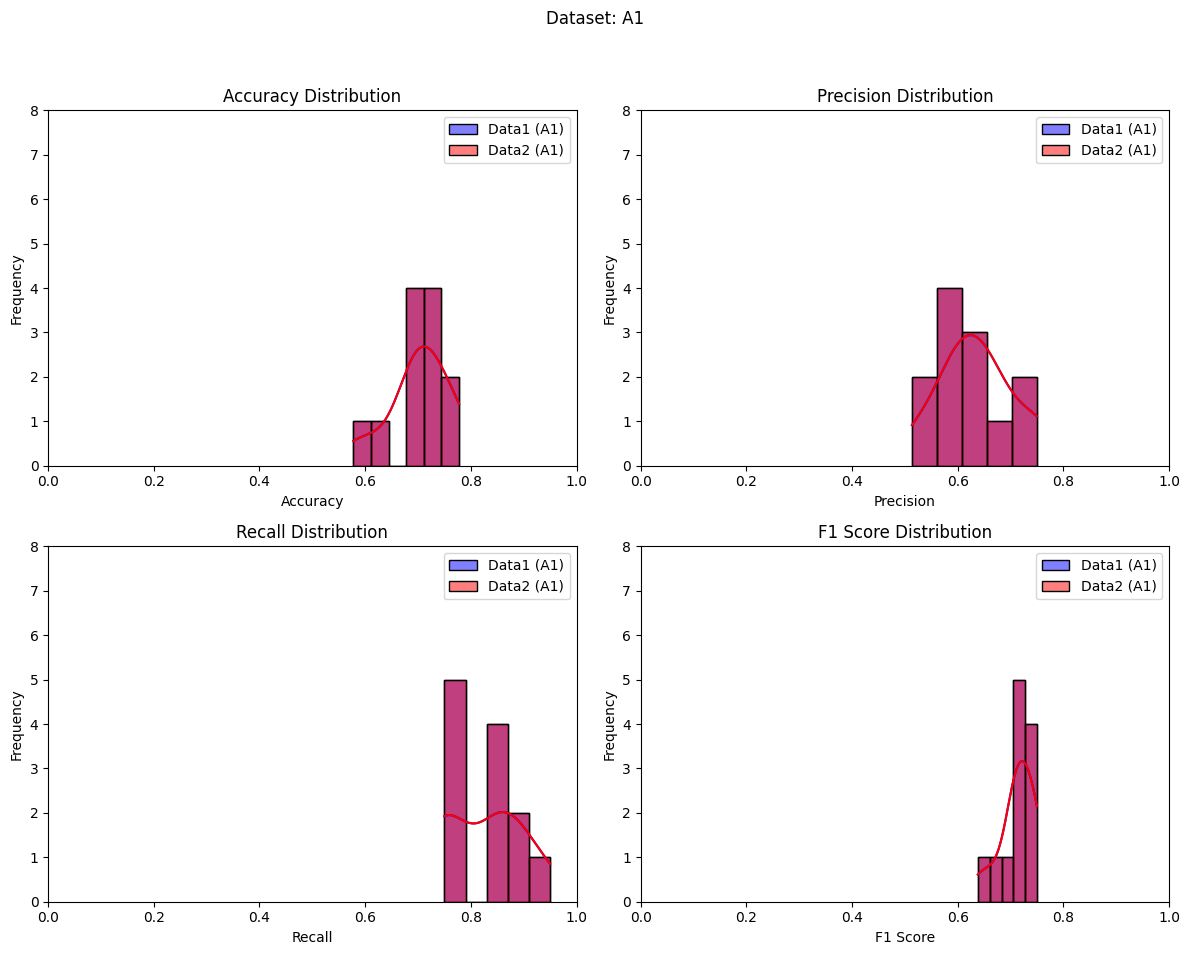

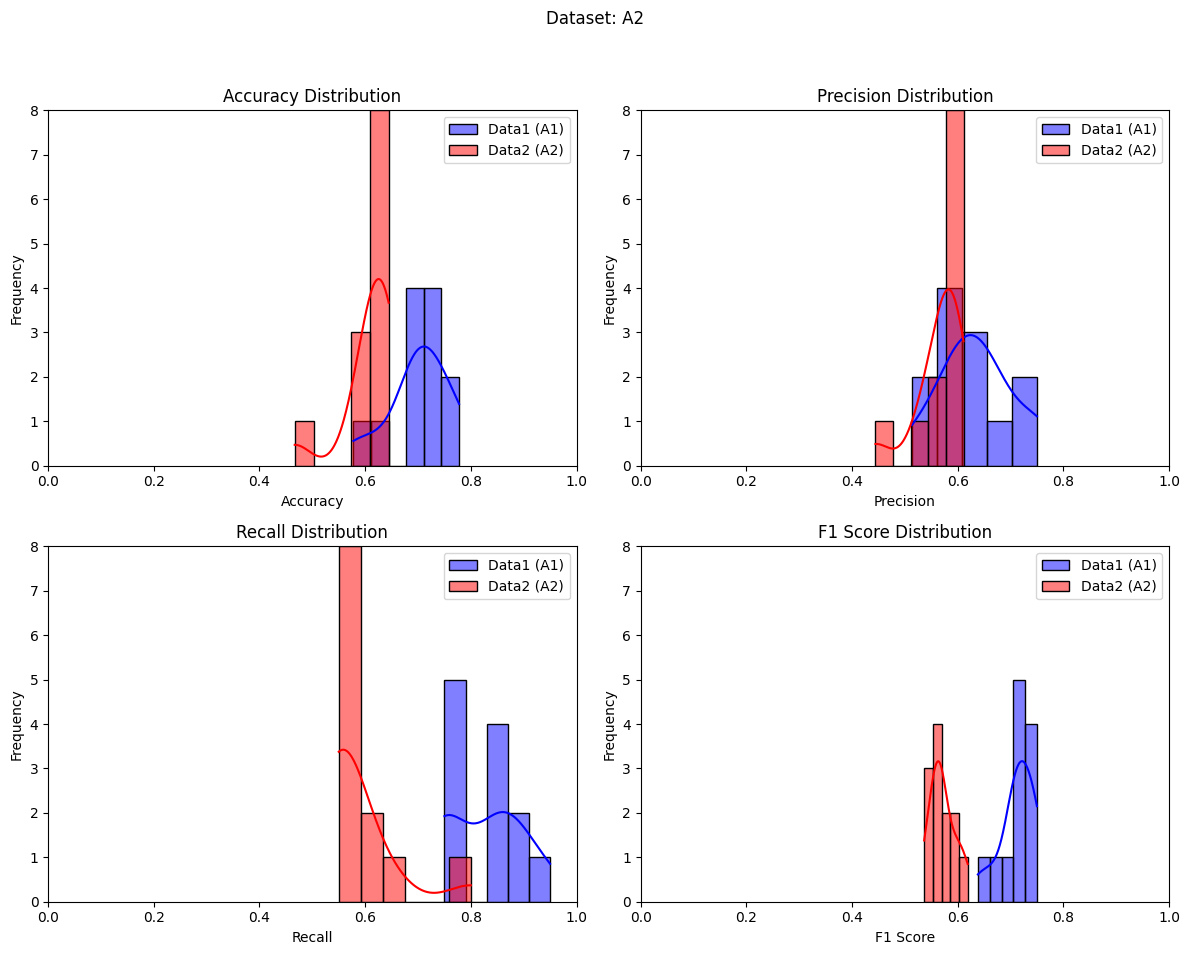

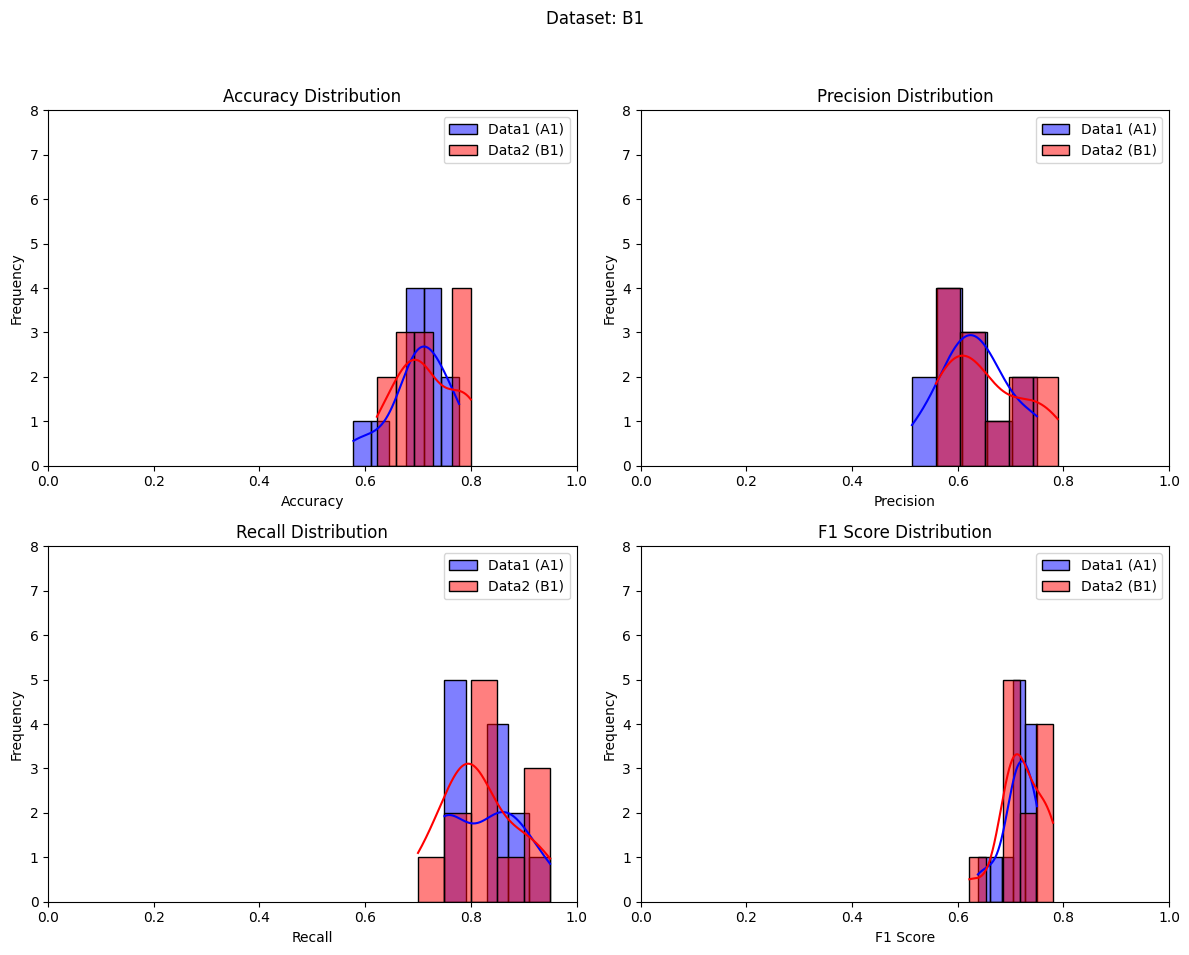

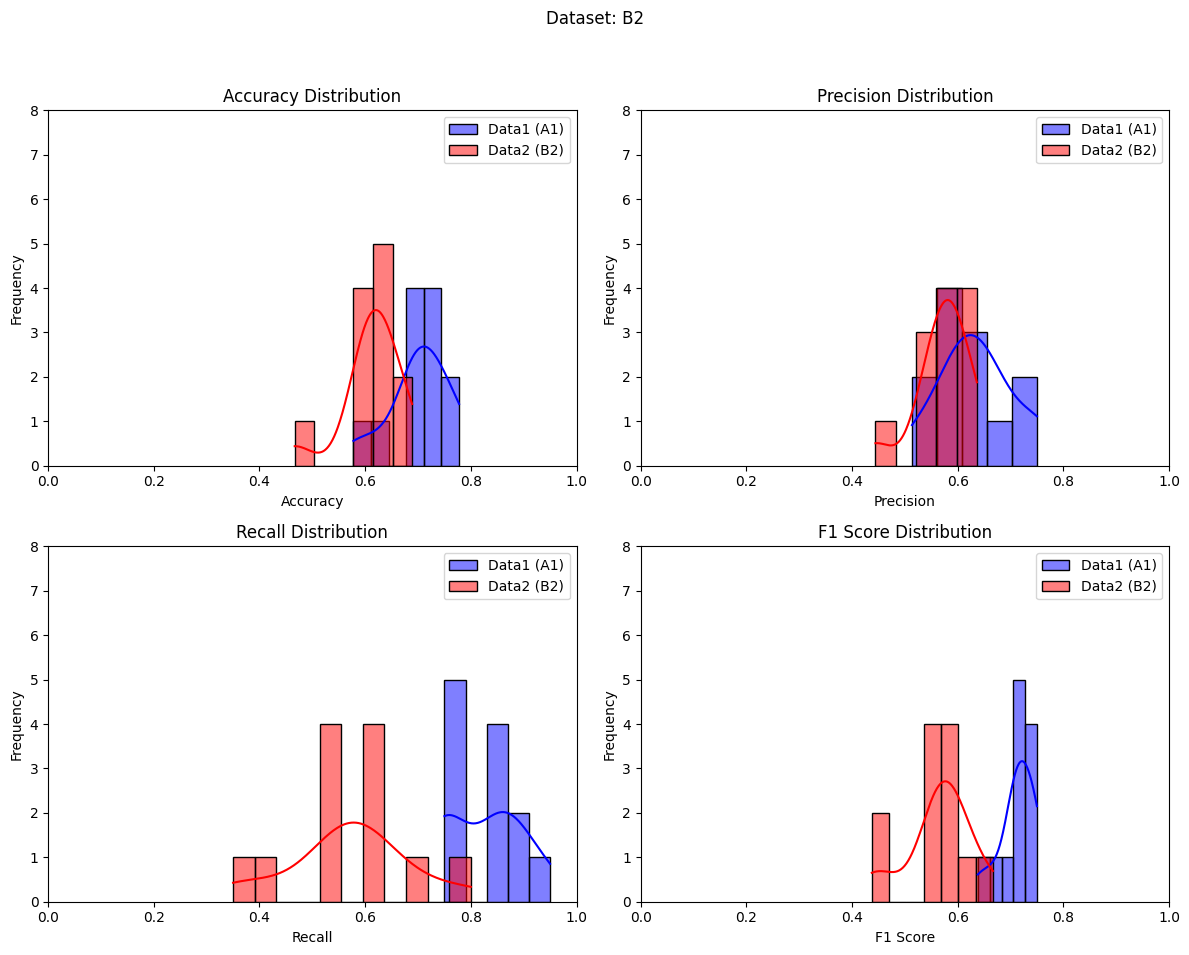

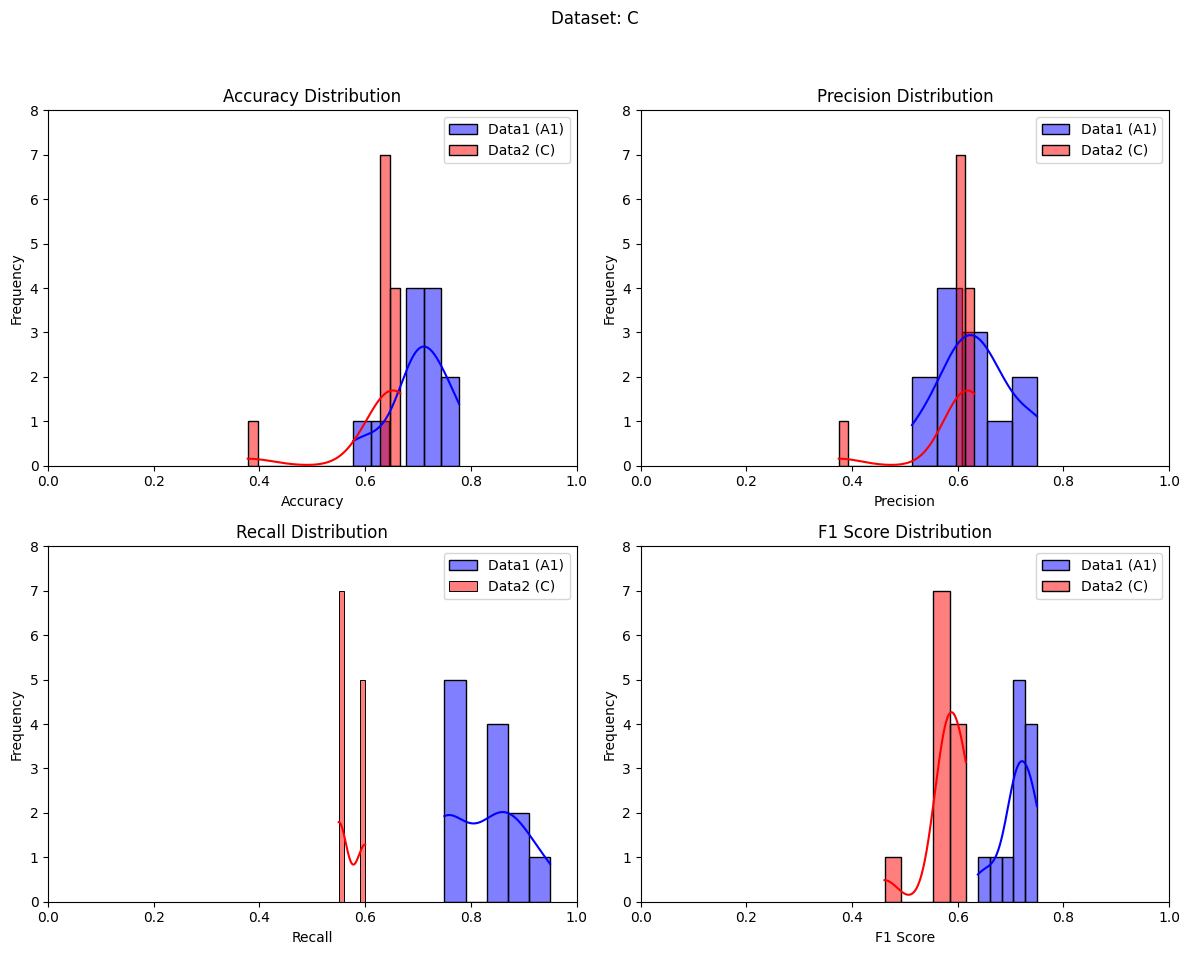

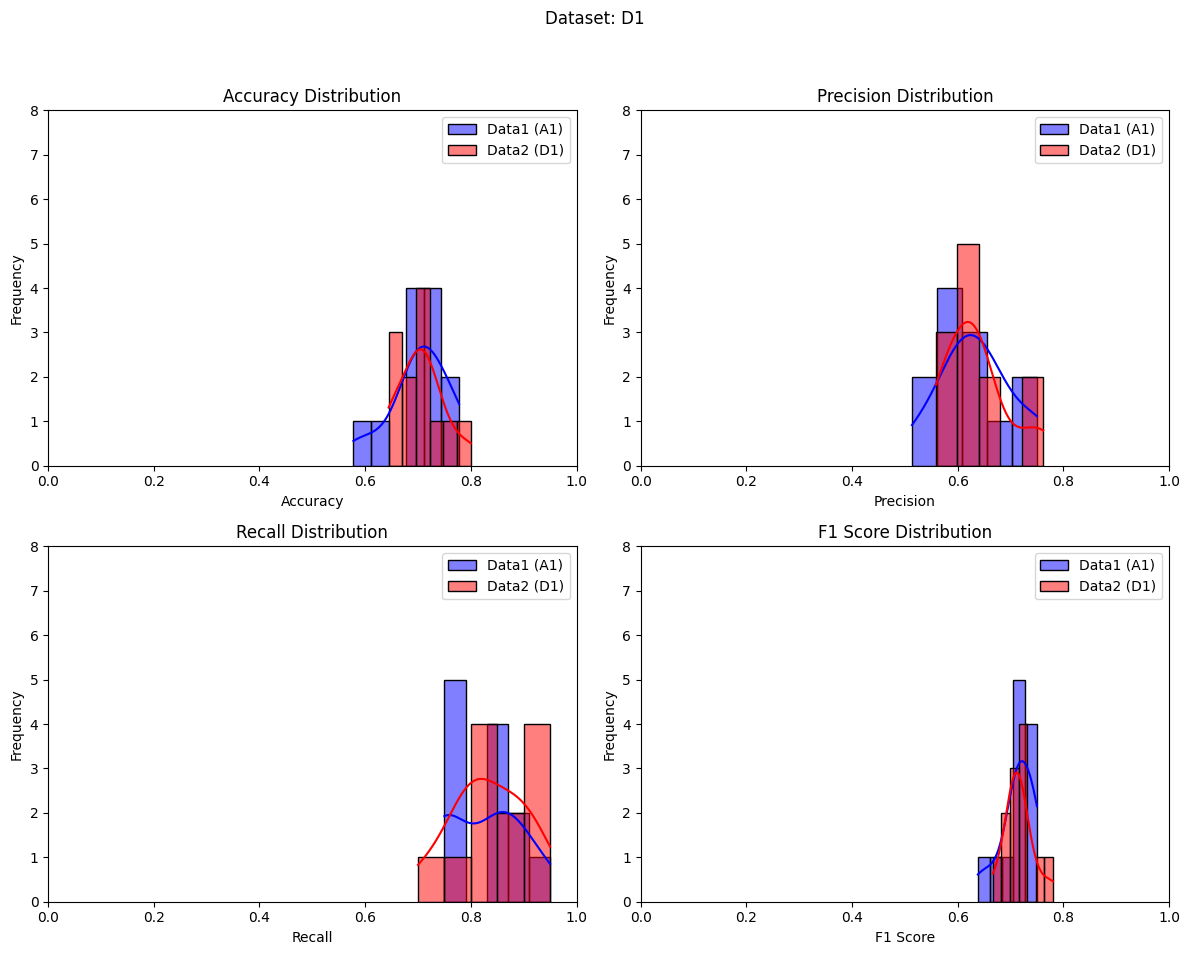

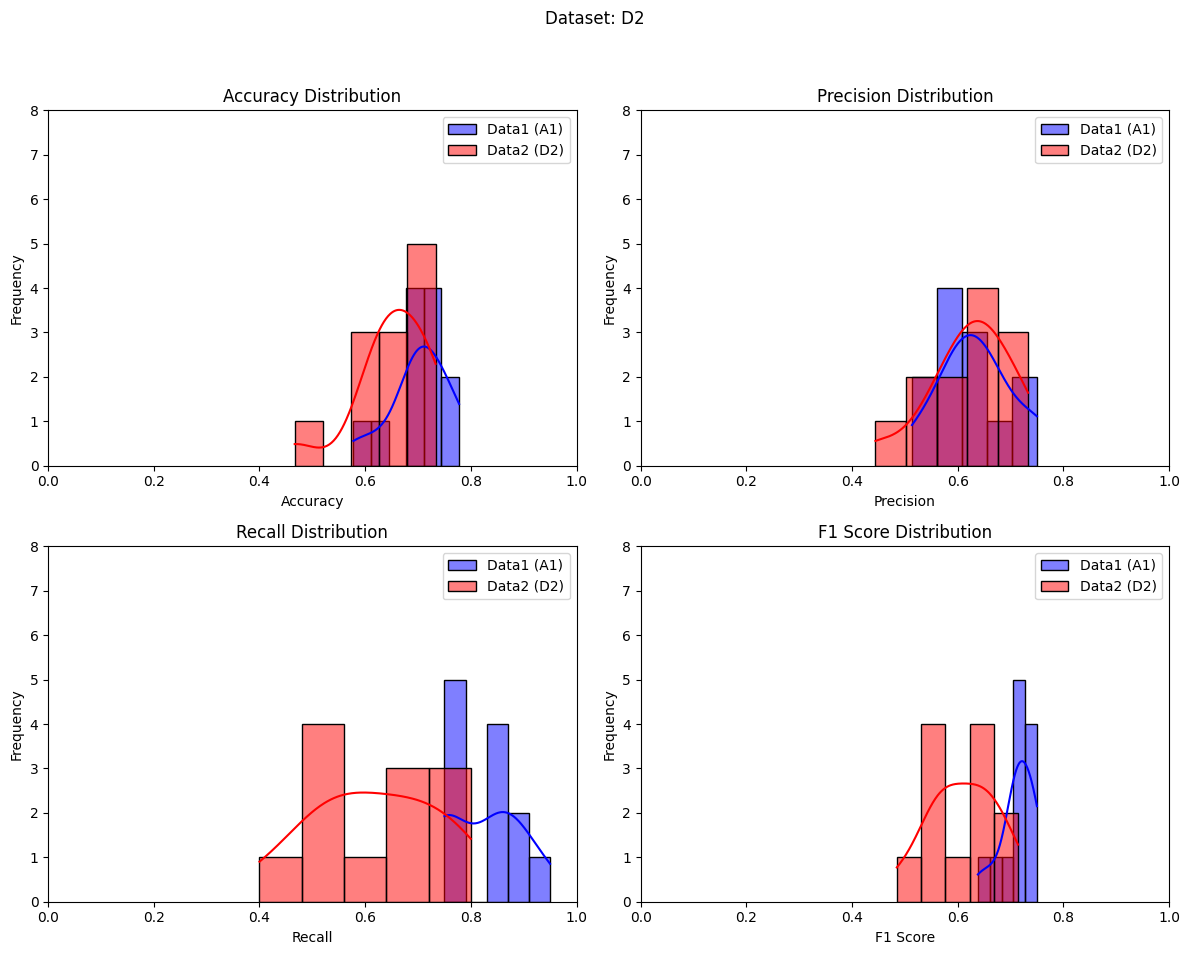

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get unique datasets
unique_datasets = dataset_results_consolidated['Dataset'].unique()

# Define the range for x-axis and y-axis
x_range = (0, 1)  # Example range for x-axis
y_range = (0, 8)  # Example range for y-axis

# Iterate over each dataset
for dataset in unique_datasets:
    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Iterate over each metric
    for i, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1 Score']):
        # Filter data for the current dataset and metric
        test1_data = dataset_results_consolidated[dataset_results_consolidated['Dataset'] == 'A1'][metric]
        test2_data = dataset_results_consolidated[dataset_results_consolidated['Dataset'] == dataset][metric]
        
        # Determine the subplot position
        row = i // 2
        col = i % 2
        
        # Plot overlapped distributions in the respective subplot
        sns.histplot(test1_data, color='blue', label='Data1 (A1)', kde=True, ax=axes[row, col])
        sns.histplot(test2_data, color='red', label=f'Data2 ({dataset})', kde=True, ax=axes[row, col])
        axes[row, col].set_title(f'{metric} Distribution')
        axes[row, col].set_xlabel(metric)
        axes[row, col].set_ylabel('Frequency')
        axes[row, col].legend()
        
        # Set fixed ranges for x-axis and y-axis
        axes[row, col].set_xlim(x_range)
        axes[row, col].set_ylim(y_range)

    # Adjust layout
    plt.suptitle(f'Dataset: {dataset}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
